# Import Libaries

In [1]:
import argparse
import warnings
from pathlib import Path
from pprint import pprint
import matplotlib.pyplot as plt
import time
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import optuna
import copy

from torch.optim.lr_scheduler import ReduceLROnPlateau
# import mse 
from sklearn.metrics import mean_squared_error
import pandas as pd
from utils.ml_helper_functions import load_data, load_data_v2

import torch.nn as nn

torch.manual_seed(42)

np.random.seed(42)

/gxfs_home/geomar/smomw693/Documents/GEOMAR-DeepLearning/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

In [2]:
df_loaded = load_data()


Loading data from:
../data/numerical_data/points30
../data/numerical_data/points10

Loading ocean, weather and insitu data...

Shapes of loaded DataFrames before feature engineering:
Ocean DataFrame: (9415187, 14)
Weather DataFrame: (2018400, 22)
Insitu DataFrame: (20161, 2)

Feature engineering...

Shapes of loaded DataFrames after feature engineering:
Ocean DataFrame: (9415187, 11)
Weather DataFrame: (2018400, 8)
Insitu DataFrame: (20161, 2)

Converting DataFrames to xarray DataArrays...

Running EOF analysis on ocean and weather data...

Converting DataArrays with PCs back to DataFrames...

Merging PCs with insitu data...

Shape of merged DataFrame with PCs: (20161, 98)

Preparing ML data...

Sum of NaN values in each column:
ds              0
bottomT_PC_1    0
bottomT_PC_2    0
bottomT_PC_3    0
bottomT_PC_4    0
               ..
wind_v_PC_6     0
wind_v_PC_7     0
wind_v_PC_8     0
y               0
unique_id       0
Length: 99, dtype: int64
Shape of prepared ML DataFrame: (2016

In [3]:
df = df_loaded.copy()

In [4]:
df.shape

(20161, 99)

In [5]:
df.head()

,ds,bottomT_PC_1,bottomT_PC_2,bottomT_PC_3,bottomT_PC_4,sla_PC_1,sla_PC_2,sla_PC_3,so_PC_1,so_PC_2,...,wind_v_PC_1,wind_v_PC_2,wind_v_PC_3,wind_v_PC_4,wind_v_PC_5,wind_v_PC_6,wind_v_PC_7,wind_v_PC_8,y,unique_id
0,2022-12-03 00:00:00,-0.303945,-1.571631,-0.796631,0.568800,-1.005268,-0.822924,0.530070,-0.218220,-0.897083,...,-0.910458,-1.380508,-0.336356,-0.663772,-0.176910,1.683785,0.216442,-1.537871,0.487133,Flensburg
1,2022-12-03 01:00:00,-0.305888,-1.570625,-0.795225,0.571684,-1.002811,-0.833910,0.528256,-0.210618,-0.893305,...,-0.891139,-1.419401,-0.342445,-0.626422,-0.157994,1.578949,-0.004670,-1.594176,0.463563,Flensburg
2,2022-12-03 02:00:00,-0.306904,-1.571336,-0.795739,0.570574,-1.006549,-0.904703,0.446098,-0.205510,-0.893562,...,-0.854349,-1.451191,-0.345683,-0.446534,-0.018121,1.552726,-0.105363,-1.581817,0.373853,Flensburg
3,2022-12-03 03:00:00,-0.308250,-1.573073,-0.795607,0.568620,-1.015887,-1.027999,0.293744,-0.205313,-0.898010,...,-0.807180,-1.425731,-0.376710,-0.361506,0.143657,1.486232,-0.122655,-1.909946,0.285051,Flensburg
4,2022-12-03 04:00:00,-0.309479,-1.574358,-0.794477,0.567034,-1.026219,-1.160469,0.123971,-0.204544,-0.909398,...,-0.740946,-1.414792,-0.440172,-0.340720,0.269567,1.562165,-0.147440,-2.029732,0.238839,Flensburg


In [6]:
df.drop(columns=["unique_id"], inplace=True)

In [7]:
# Calculating lagged features for all the columns which are numerical
for col in df.select_dtypes(include=[np.number]).columns:
    for lag in range(1, 7):
        df[f"{col}_lag_{lag}"] = df[col].shift(lag)

        #df[f'{col}_future_{lag}'] = df[col].shift(-lag)

df.dropna(inplace=True)

In [8]:
df.head()

,ds,bottomT_PC_1,bottomT_PC_2,bottomT_PC_3,bottomT_PC_4,sla_PC_1,sla_PC_2,sla_PC_3,so_PC_1,so_PC_2,...,wind_v_PC_8_lag_3,wind_v_PC_8_lag_4,wind_v_PC_8_lag_5,wind_v_PC_8_lag_6,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5,y_lag_6
6,2022-12-03 06:00:00,-0.312929,-1.577621,-0.789427,0.565287,-1.046446,-1.316206,-0.095753,-0.192486,-0.961201,...,-1.909946,-1.581817,-1.594176,-1.537871,0.190879,0.238839,0.285051,0.373853,0.463563,0.487133
7,2022-12-03 07:00:00,-0.315194,-1.578574,-0.785857,0.566916,-1.046160,-1.291914,-0.069276,-0.184501,-0.989670,...,-2.029732,-1.909946,-1.581817,-1.594176,0.123832,0.190879,0.238839,0.285051,0.373853,0.463563
8,2022-12-03 08:00:00,-0.317464,-1.579160,-0.783296,0.569445,-1.041916,-1.206734,0.043078,-0.177240,-1.006346,...,-1.917860,-2.029732,-1.909946,-1.581817,0.114784,0.123832,0.190879,0.238839,0.285051,0.373853
9,2022-12-03 09:00:00,-0.319518,-1.579340,-0.781233,0.572660,-1.033751,-1.081472,0.210686,-0.170365,-1.011441,...,-1.804758,-1.917860,-2.029732,-1.909946,0.143285,0.114784,0.123832,0.190879,0.238839,0.285051
10,2022-12-03 10:00:00,-0.320767,-1.578249,-0.779827,0.576759,-1.028013,-0.951460,0.384692,-0.164178,-1.005075,...,-1.722601,-1.804758,-1.917860,-2.029732,0.229517,0.143285,0.114784,0.123832,0.190879,0.238839


In [9]:
# get the data from 21.10.2023 und zwei wochen vorher und danach
time_delta = pd.Timedelta(days=48) # 2 weeks
surge_date = pd.Timestamp("2023-10-21")
start_date = surge_date - time_delta
end_date = surge_date + time_delta

<Axes: title={'center': 'Surge Data'}, xlabel='ds'>

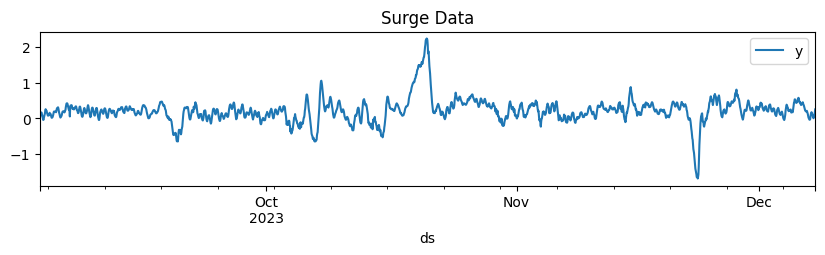

In [10]:
df_surge = df.loc[df.ds > start_date][df.ds < end_date].copy()
df_surge.plot(x="ds", y="y", kind="line", figsize=(10, 2), title="Surge Data")

<Axes: title={'center': 'Surge Data with NaN'}, xlabel='ds'>

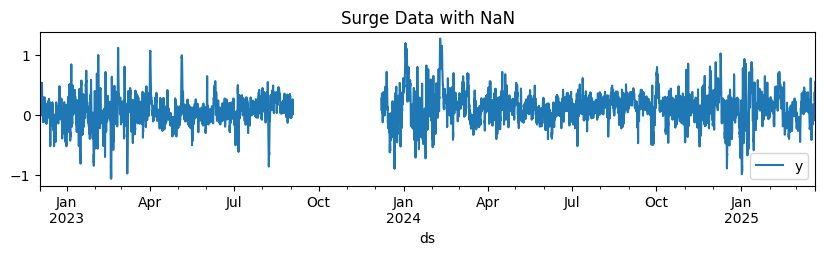

In [11]:
# make NaN values in range of start_date and end_date for all columns except 'ds'
df.loc[(df.ds > start_date) & (df.ds < end_date), df.columns != 'ds'] = np.nan

df.plot(x='ds', y="y", kind="line", figsize=(10, 2), title="Surge Data with NaN")



In [12]:
df_train = df.loc[df.ds < '2025-01-01'].copy()
df_val = df.loc[df.ds >= '2025-01-01'].copy()

In [13]:
display(df_train)
display(df_val)

,ds,bottomT_PC_1,bottomT_PC_2,bottomT_PC_3,bottomT_PC_4,sla_PC_1,sla_PC_2,sla_PC_3,so_PC_1,so_PC_2,...,wind_v_PC_8_lag_3,wind_v_PC_8_lag_4,wind_v_PC_8_lag_5,wind_v_PC_8_lag_6,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5,y_lag_6
6,2022-12-03 06:00:00,-0.312929,-1.577621,-0.789427,0.565287,-1.046446,-1.316206,-0.095753,-0.192486,-0.961201,...,-1.909946,-1.581817,-1.594176,-1.537871,0.190879,0.238839,0.285051,0.373853,0.463563,0.487133
7,2022-12-03 07:00:00,-0.315194,-1.578574,-0.785857,0.566916,-1.046160,-1.291914,-0.069276,-0.184501,-0.989670,...,-2.029732,-1.909946,-1.581817,-1.594176,0.123832,0.190879,0.238839,0.285051,0.373853,0.463563
8,2022-12-03 08:00:00,-0.317464,-1.579160,-0.783296,0.569445,-1.041916,-1.206734,0.043078,-0.177240,-1.006346,...,-1.917860,-2.029732,-1.909946,-1.581817,0.114784,0.123832,0.190879,0.238839,0.285051,0.373853
9,2022-12-03 09:00:00,-0.319518,-1.579340,-0.781233,0.572660,-1.033751,-1.081472,0.210686,-0.170365,-1.011441,...,-1.804758,-1.917860,-2.029732,-1.909946,0.143285,0.114784,0.123832,0.190879,0.238839,0.285051
10,2022-12-03 10:00:00,-0.320767,-1.578249,-0.779827,0.576759,-1.028013,-0.951460,0.384692,-0.164178,-1.005075,...,-1.722601,-1.804758,-1.917860,-2.029732,0.229517,0.143285,0.114784,0.123832,0.190879,0.238839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18235,2024-12-31 19:00:00,-0.584131,-0.614013,-0.269621,0.283882,1.457615,1.305080,-0.568677,1.257056,0.600762,...,0.818313,0.727700,0.394720,-0.107754,0.065000,0.168333,0.205000,0.241667,0.206667,0.103333
18236,2024-12-31 20:00:00,-0.587652,-0.613196,-0.263441,0.285923,1.479896,1.303972,-1.022421,1.293841,0.604203,...,1.022324,0.818313,0.727700,0.394720,-0.110000,0.065000,0.168333,0.205000,0.241667,0.206667
18237,2024-12-31 21:00:00,-0.589287,-0.612524,-0.259115,0.286310,1.492575,1.319430,-1.482426,1.324701,0.598391,...,1.635409,1.022324,0.818313,0.727700,-0.265000,-0.110000,0.065000,0.168333,0.205000,0.241667
18238,2024-12-31 22:00:00,-0.590708,-0.611164,-0.255194,0.285727,1.496793,1.409592,-1.872253,1.346701,0.590851,...,1.434405,1.635409,1.022324,0.818313,-0.316667,-0.265000,-0.110000,0.065000,0.168333,0.205000


,ds,bottomT_PC_1,bottomT_PC_2,bottomT_PC_3,bottomT_PC_4,sla_PC_1,sla_PC_2,sla_PC_3,so_PC_1,so_PC_2,...,wind_v_PC_8_lag_3,wind_v_PC_8_lag_4,wind_v_PC_8_lag_5,wind_v_PC_8_lag_6,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5,y_lag_6
18240,2025-01-01 00:00:00,-0.594749,-0.606518,-0.246635,0.290304,1.511220,1.961435,-2.320812,1.362626,0.582624,...,1.796824,1.608027,1.434405,1.635409,-0.516667,-0.393333,-0.316667,-0.265000,-0.110000,0.065000
18241,2025-01-01 01:00:00,-0.596070,-0.601875,-0.232467,0.269744,1.500847,2.286545,-2.458659,1.368198,0.591566,...,2.533280,1.796824,1.608027,1.434405,-0.536667,-0.516667,-0.393333,-0.316667,-0.265000,-0.110000
18242,2025-01-01 02:00:00,-0.597046,-0.598618,-0.229393,0.266700,1.470679,2.576662,-2.557171,1.370120,0.598481,...,2.682510,2.533280,1.796824,1.608027,-0.566667,-0.536667,-0.516667,-0.393333,-0.316667,-0.265000
18243,2025-01-01 03:00:00,-0.598216,-0.595379,-0.227157,0.267686,1.428973,2.839926,-2.605468,1.371592,0.607398,...,2.555156,2.682510,2.533280,1.796824,-0.638333,-0.566667,-0.536667,-0.516667,-0.393333,-0.316667
18244,2025-01-01 04:00:00,-0.598849,-0.591694,-0.224628,0.263314,1.385750,3.037917,-2.669885,1.371422,0.617123,...,1.738916,2.555156,2.682510,2.533280,-0.676667,-0.638333,-0.566667,-0.536667,-0.516667,-0.393333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20156,2025-03-21 20:00:00,-0.852832,0.304002,0.242566,-0.543267,-0.450593,-1.642004,0.088681,-0.618588,-0.563127,...,-0.175218,-0.095271,-0.441699,-0.723018,0.420000,0.336667,0.275000,0.231667,0.245000,0.278333
20157,2025-03-21 21:00:00,-0.854031,0.301599,0.241763,-0.543499,-0.465324,-1.552174,0.280006,-0.615991,-0.559928,...,-0.506669,-0.175218,-0.095271,-0.441699,0.483333,0.420000,0.336667,0.275000,0.231667,0.245000
20158,2025-03-21 22:00:00,-0.855638,0.299369,0.241838,-0.543754,-0.475831,-1.457704,0.445328,-0.610756,-0.563381,...,-0.701652,-0.506669,-0.175218,-0.095271,0.496667,0.483333,0.420000,0.336667,0.275000,0.231667
20159,2025-03-21 23:00:00,-0.857216,0.297495,0.242355,-0.543240,-0.483009,-1.387714,0.528586,-0.603634,-0.579456,...,-1.052708,-0.701652,-0.506669,-0.175218,0.538333,0.496667,0.483333,0.420000,0.336667,0.275000


In [14]:
def create_sequences(df, seq_len=168, horizon=1):
    """
    Erzeugt nur Sequenzen, die innerhalb eines zusammenhängenden Bereichs liegen.
    """

    X_data = df.drop(columns=["y"]).set_index("ds").to_numpy()
    y_data = df[["ds", "y"]].set_index("ds").to_numpy()



    X, y = [], []
    for i in range(len(X_data) - seq_len - horizon + 1):
        window_x = X_data[i:i+seq_len+horizon] 
        window_y = y_data[i:i+seq_len+horizon]

        # Sicherheitscheck: Kein NaN und Index ist lückenlos
        if np.any(np.isnan(window_x)) or np.any(np.isnan(window_y)):
            continue  # überspringen
        X.append(window_x[:seq_len])
        y.append(window_y[seq_len:seq_len+horizon, 0])  
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(df_train, seq_len=168, horizon=168)
X_val, y_val = create_sequences(df_val, seq_len=168, horizon=168)
X_test, y_test = create_sequences(df_surge, seq_len=168, horizon=168)

print("\nTrain shapes:")
print(X_train.shape, y_train.shape, type(X_train), type(y_train))

print("\nValidation shapes:")
print(X_val.shape, y_val.shape, type(X_val), type(y_val))

print("\nTest shapes:")
print(X_test.shape, y_test.shape, type(X_test), type(y_test))


Train shapes:
(15261, 168, 678) (15261, 168) <class 'numpy.ndarray'> <class 'numpy.ndarray'>

Validation shapes:
(1586, 168, 678) (1586, 168) <class 'numpy.ndarray'> <class 'numpy.ndarray'>

Test shapes:
(1968, 168, 678) (1968, 168) <class 'numpy.ndarray'> <class 'numpy.ndarray'>


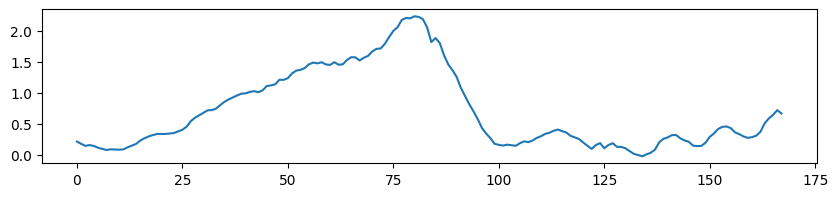

In [15]:
plt.figure(figsize=(10, 2))
plt.plot(y_test[900], label='Surge Data')
plt.show()

In [16]:
# Scaling x data


x_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val_scaled = x_scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test_scaled = x_scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)



print("Scaled shapes:")
print(X_train_scaled.shape, y_train.shape, type(X_train_scaled), type(y_train))
print(X_val_scaled.shape, y_val.shape, type(X_val_scaled), type(y_val))
print(X_test_scaled.shape, y_test.shape, type(X_test_scaled), type(y_test))

Scaled shapes:
(15261, 168, 678) (15261, 168) <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1586, 168, 678) (1586, 168) <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1968, 168, 678) (1968, 168) <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [17]:
# # Scaling y_train and y_test
# y_scaler = StandardScaler()
# y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).reshape(y_train.shape)
# y_val_scaled = y_scaler.transform(y_val.reshape(-1, 1)).reshape(y_val.shape)
# y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).reshape(y_test.shape)

# print("Scaled y shapes:")
# print(y_train_scaled.shape, type(y_train_scaled))
# print(y_val_scaled.shape, type(y_val_scaled))
# print(y_test_scaled.shape, type(y_test_scaled))

In [18]:
import torch

# Numpy → Tensor
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

print("\nTensor shapes:")
print(X_train_tensor.shape, y_train_tensor.shape, type(X_train_tensor), type(y_train_tensor))
print(X_val_tensor.shape, y_val_tensor.shape, type(X_val_tensor), type(y_val_tensor))
print(X_test_tensor.shape, y_test_tensor.shape, type(X_test_tensor), type(y_test_tensor))


Tensor shapes:
torch.Size([15261, 168, 678]) torch.Size([15261, 168]) <class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([1586, 168, 678]) torch.Size([1586, 168]) <class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([1968, 168, 678]) torch.Size([1968, 168]) <class 'torch.Tensor'> <class 'torch.Tensor'>


In [19]:
class LSTMPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, output_horizon=168, n_classes=5, dropout=0.2):
        super(LSTMPredictor, self).__init__()
        self.output_horizon = output_horizon
        self.n_classes = n_classes



        self.lstm = nn.LSTM(input_size=input_dim,
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout)


        
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LeakyReLU(),
            nn.Dropout(dropout)
        )

        self.reg_out = nn.Linear(hidden_dim // 2, output_horizon)

        self.class_out = nn.Linear(hidden_dim // 2, output_horizon * n_classes)

    

    def forward(self, x):
        # x: (batch_size, seq_len, input_dim)
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Nur letzter Zeitschritt
        x = self.fc(x)        # (batch_size, hidden_dim // 2)
        reg_out = self.reg_out(x)            # (batch_size, output_horizon)
        class_out = self.class_out(x)                         # (batch_size, output_horizon * n_classes)
        class_out = class_out.view(-1, self.output_horizon, self.n_classes)  # (batch_size, output_horizon, n_classes)

        return reg_out, class_out

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            if x.dim() == 2:
                # Einzelne Sequenz: (seq_len, input_dim)
                x = x.unsqueeze(0)  # → (1, seq_len, input_dim)
                output = self.forward(x)
                return output.squeeze(0)  # → (output_horizon,)
            elif x.dim() == 3:
                # Batch: (batch_size, seq_len, input_dim)
                return self.forward(x)  # → (batch_size, output_horizon)
            else:
                raise ValueError(f"Unexpected input dimension: {x.shape}")



In [20]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class LSTMWaterLevelPredictor(nn.Module):
#     def __init__(self, input_dim, hidden_dim, num_layers, forecast_horizon, num_classes=5):
#         super().__init__()
#         self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim,
#                             num_layers=num_layers, batch_first=True)
#         self.reg_head = nn.Linear(hidden_dim, forecast_horizon)  # Regression: Pegelwerte
#         self.class_head = nn.Linear(hidden_dim, num_classes)     # Klassifikation: Klassenlabel

#     def forward(self, x):
#         lstm_out, _ = self.lstm(x)
#         last_hidden = lstm_out[:, -1, :]  # letzter Zeitschritt
#         reg_out = self.reg_head(last_hidden)           # (batch, forecast_horizon)
#         class_out = self.class_head(last_hidden)    # (batch, num_classes)
#         return reg_out, class_out


# def train(model, dataloader, epochs=20, lr=1e-3, alpha=0.7, bins=[1, 1.25, 1.5, 2.0]):
#     model.train()
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#     mse_loss = nn.MSELoss()
#     ce_loss = nn.CrossEntropyLoss()

#     for epoch in range(epochs):
#         total_loss = 0
#         for X_batch, y_reg_batch in dataloader:
#             optimizer.zero_grad()

#             # Ziel-Klassenlabel: z. B. basierend auf Mittelwert des Forecast-Ziels
#             y_mean = y_reg_batch.mean(dim=1).detach().cpu().numpy()  # (batch,)
#             y_class = np.digitize(y_mean, bins)
#             y_class = torch.tensor(y_class, dtype=torch.long, device=X_batch.device)

#             # Vorhersage
#             reg_pred, class_logits = model(X_batch)

#             loss_r = mse_loss(reg_pred, y_reg_batch)
#             loss_c = ce_loss(class_logits, y_class)

#             loss = alpha * loss_c + (1 - alpha) * loss_r
#             loss.backward()
#             optimizer.step()
#             total_loss += loss.item()

#         avg_loss = total_loss / len(dataloader)
#         print(f"Epoch {epoch+1}: Combined Loss = {avg_loss:.4f}")


In [21]:
X_train.shape[2]

678

y_reg_batch = tensor([
    [0.9, 1.1, 1.3],   # → Klassen [0, 1, 2]
    [1.4, 1.6, 2.1],   # → Klassen [2, 3, 4]
    [0.8, 1.0, 1.2]    # → Klassen [0, 1, 1]
])


bins = [1.0, 1.25, 1.5, 2.0]
→ ergibt Klassen:
< 1.00       → Klasse 0
1.00–1.24    → Klasse 1
1.25–1.49    → Klasse 2
1.50–1.99    → Klasse 3
≥ 2.00       → Klasse 4


In [22]:
lr = 0.01  # Learning rate

model = LSTMPredictor(input_dim=X_train.shape[2], output_horizon=168, dropout=0.2)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

In [ ]:


def training(model, X_train, y_train, X_val, y_val, optimizer, epochs, writer, batch_size=64, patience=50, dropout_prob=0.5, log_tensorboard=True, log_dropout=True, verbose=True):

    # Set device to GPU if available
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

    # Move data and model to device
    X_train, y_train, X_val, y_val = X_train.to(device), y_train.to(device), X_val.to(device), y_val.to(device)
    model.to(device)

    # Initialize best metrics and model
    best_val_metric = float('inf') # Initialize the best_eval_metric
    best_val_loss = float('inf') # Initialize the best_val_loss
    best_model = copy.deepcopy(model.state_dict()) # Initialize the best_model
    patience_counter_loss = 0  # Early stopping counter
    patience_counter_metric = 0  # Early stopping counter

    # DataLoader for batching
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)


    # Scheduler for learning rate adjustment (if val_loss does not improve for 'patience' epochs)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
    train_losses, val_losses = [], [] # to visualize the drop_out_prob
    train_mses, val_mses = [], []

    mse_loss = nn.MSELoss()
    ce_loss = nn.CrossEntropyLoss()

    bins = torch.tensor([1.0, 1.25, 1.5, 2.0], device=device)
    alpha = 0.7  # Weight for classification loss

    n_classes = 5  # Number of classes for classification

    # Training Loop
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        # Training loop
        for X_batch_train, y_batch_train in train_loader:
            X_batch_train, y_batch_train = X_batch_train.to(device), y_batch_train.to(device)

            optimizer.zero_grad()  # Clear gradients
            reg_out_train, class_out_train = model(X_batch_train)  # Forward pass
            y_class_batch = torch.bucketize(y_batch_train, bins)  # (batch_size, output_horizon)

            # Output: class_out_train: (batch_size, output_horizon, n_classes)
            # Target: y_class_batch:  (batch_size, output_horizon)
            

            class_loss_train = ce_loss(
                class_out_train.view(-1, n_classes),         # (batch_size * horizon, n_classes)
                y_class_batch.view(-1)                       # (batch_size * horizon)
            )

            
            reg_loss_train = mse_loss(reg_out_train, y_batch_train)

            loss = alpha * class_loss_train + (1 - alpha) * reg_loss_train


            #loss = criterion(y_pred_train, y_batch_train)  # Calculate loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            epoch_loss += loss.item()  # Accumulate batch loss

        # Validation
        model.eval()
        with torch.no_grad():
            reg_out_val, class_out_val = model(X_val) # Forward pass
            y_class_val = torch.bucketize(y_val, bins)  # (batch_size, output_horizon)

            class_loss_val = ce_loss(
                class_out_val.view(-1, n_classes),         # (batch_size * horizon, n_classes)
                y_class_val.view(-1)                       # (batch_size * horizon)
            )

            reg_loss_val = mse_loss(reg_out_val, y_val)

            loss_val = alpha * class_loss_val + (1 - alpha) * reg_loss_val
            scheduler.step(loss_val)  # Adjust learning rate based on loss
            
            # calculate the training accuracy
            predictions_train, _ = model.predict(X_train)
            mse_train = mean_squared_error(y_train.cpu(), predictions_train.cpu())

            # Calculate validation accuracy
            predictions_val, _ = model.predict(X_val)
            mse_val = mean_squared_error(y_val.cpu(), predictions_val.cpu())

            # Log to dropout_results
            if log_dropout:
              train_losses.append(epoch_loss / len(train_loader))
              val_losses.append(loss_val.item())
              train_mses.append(mse_train)
              val_mses.append(mse_val)

            # Log to TensorBoard
            if log_tensorboard:
              writer.add_scalars("Loss", {"train": epoch_loss / len(train_loader), 'val': loss_val}, epoch)
              writer.add_scalars("MSE", {"train": mse_train, "val": mse_val}, epoch)
              #writer.add_scalar("Accuracy/val", accuracy_val, epoch)
              writer.flush()

            # Early stopping if loss_val is increasing
            if loss_val < best_val_loss:
                best_val_loss = loss_val  # Update best val_loss
                patience_counter_loss = 0  # Reset patience counter
            else:
                patience_counter_loss += 1  # Increment if no improvement

            # Early Stopping based on if val_mse in not increasing
            if mse_val < best_val_metric:
                best_val_metric = mse_val
                best_model = copy.deepcopy(model.state_dict()) # saves the best model where the mse_val is lowest
                patience_counter_metric = 0  # Reset patience counter if improved
            else:
                patience_counter_metric += 1

            # Early stopping check
            if (patience_counter_loss >= patience) or (patience_counter_metric >= patience):
                print(f"Early stopping at epoch {epoch+1}")
                break


        # Print status
        if verbose:
          if epoch % 1 == 0:
            print(f"| Epoch {epoch+1} | Train Loss: {epoch_loss / len(train_loader):.4f}, Validation Loss: {loss_val:.4f} | Train MSE: {mse_train:.4f}, Val MSE: {mse_val:.4f} |")


    # Load the best model
    model.load_state_dict(best_model)
    print(f"Best validation MSE: {best_val_metric:.4f}")

    writer.close()
    return model



In [ ]:
best_model = training(model=model,
                    X_train=X_train_tensor, 
                    y_train=y_train_tensor, 
                    X_val=X_val_tensor, 
                    y_val=y_val_tensor, 
                    #criterion=criterion, 
                    optimizer=optimizer, 
                    epochs=100,
                    writer=SummaryWriter(log_dir="runs/ConvLSTM"), 
                    batch_size=128, 
                    patience=3, 
                    dropout_prob=0.5, 
                    log_tensorboard=True, 
                    log_dropout=True, 
                    verbose=True)

| Epoch 1 | Train Loss: 0.0419, Validation Loss: 0.0229 | Train MSE: 0.0750, Val MSE: 0.0751 |
| Epoch 2 | Train Loss: 0.0457, Validation Loss: 0.0334 | Train MSE: 0.0950, Val MSE: 0.1110 |
| Epoch 3 | Train Loss: 0.0431, Validation Loss: 0.0395 | Train MSE: 0.1083, Val MSE: 0.1313 |
| Epoch 4 | Train Loss: 0.0393, Validation Loss: 0.0261 | Train MSE: 0.0798, Val MSE: 0.0871 |
| Epoch 5 | Train Loss: 0.0351, Validation Loss: 0.0254 | Train MSE: 0.0805, Val MSE: 0.0620 |
Best validation MSE: 0.0620


In [32]:
# Evaluate the model on the test set
y_pred_test,_ = model.predict(X_test_tensor)

# Inverse transform the predictions and ground truth
# y_test_inv = y_scaler.inverse_transform(y_test_tensor.cpu().numpy())
# y_pred_test_inv = y_scaler.inverse_transform(y_pred_test.cpu().numpy())




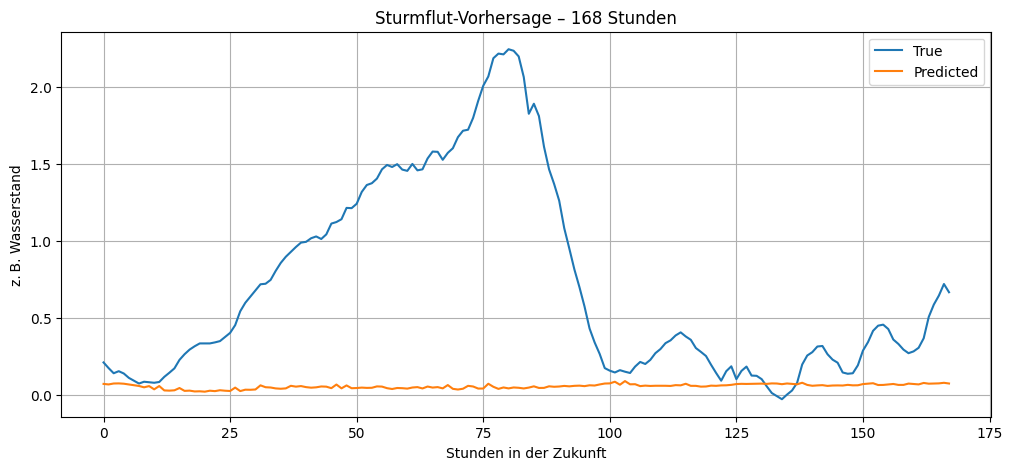

In [35]:
import matplotlib.pyplot as plt

# Beispiel: erstes Testsample
idx = 900
y_true_plot = y_test_tensor[idx].cpu().numpy()
y_pred_plot = y_pred_test[idx].cpu().numpy()


# inverse scaling
# y_true_plot = y_scaler.inverse_transform(y_true_plot.reshape(-1, 1)).reshape(-1)
# y_pred_plot = y_scaler.inverse_transform(y_pred_plot.reshape(-1, 1)).reshape(-1)

plt.figure(figsize=(12, 5))
plt.plot(y_true_plot, label="True")
plt.plot(y_pred_plot, label="Predicted")
plt.title("Sturmflut-Vorhersage – 168 Stunden")
plt.xlabel("Stunden in der Zukunft")
plt.ylabel("z. B. Wasserstand")
plt.legend()
plt.grid()
plt.show()


In [ ]:
dd

NameError: name 'dd' is not defined

In [ ]:
# [[1, 2, 3, ..., 96]]

## Sliding Window

In [ ]:
import numpy as np
import torch

def create_class_labels(y, bins=[1.0, 1.25, 1.5, 2.0]):
    """Diskretisiert kontinuierliche Werte in Klassen (für Klassifikations-Loss)."""
    return np.digitize(y, bins)


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class WeatherLevelDataset(Dataset):
    def __init__(self, X, y, input_length=96, forecast_horizon=168):
        self.X = X
        self.y = y
        self.input_length = input_length
        self.forecast_horizon = forecast_horizon

        self.indices = [
            i for i in range(len(X) - input_length - forecast_horizon)
        ]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        i = self.indices[idx]
        X_seq = self.X[i:i + self.input_length]          # (input_length, features)
        y_seq = self.y[i + self.input_length:i + self.input_length + self.forecast_horizon]  # (forecast_horizon,)
        return torch.tensor(X_seq, dtype=torch.float32), torch.tensor(y_seq.squeeze(), dtype=torch.float32)


In [ ]:
import torch.nn as nn

class LSTMWaterLevelPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, forecast_horizon):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim,
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, forecast_horizon)

    def forward(self, x):
        # x: (batch_size, seq_len, input_dim)
        lstm_out, _ = self.lstm(x)  # lstm_out: (batch_size, seq_len, hidden_dim)
        last_hidden = lstm_out[:, -1, :]  # Nehme letzten Zeitschritt
        out = self.fc(last_hidden)  # (batch_size, forecast_horizon)
        return out

def train(model, dataloader, epochs=20, lr=1e-3):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_batch in dataloader:
            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}: Loss = {total_loss / len(dataloader):.4f}")


In [ ]:
dataset = WeatherLevelDataset(X_np, y_np, input_length=96, forecast_horizon=168)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [ ]:
dataloader.dataset.X

array([[-0.30394474, -1.5716313 , -0.79663086, ...,  1.6837853 ,
         0.21644196, -1.5378712 ],
       [-0.30588815, -1.5706254 , -0.7952253 , ...,  1.5789495 ,
        -0.00466983, -1.5941759 ],
       [-0.3069036 , -1.5713363 , -0.79573905, ...,  1.5527256 ,
        -0.10536267, -1.5818166 ],
       ...,
       [-0.8556384 ,  0.29936862,  0.2418385 , ...,  0.13357161,
         0.92079157, -1.4518397 ],
       [-0.8572159 ,  0.29749537,  0.24235463, ...,  0.30787146,
         0.48959148, -1.5300517 ],
       [-0.85867804,  0.29570204,  0.24299137, ...,  0.4814613 ,
         0.31942773, -1.4051561 ]], dtype=float32)

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

X_np = X.to_numpy()
y_np = y.to_numpy()

# # Skalierung (optional aber empfohlen)
# scaler_X = StandardScaler()
# X_scaled = scaler_X.fit_transform(X_np)

# scaler_y = StandardScaler()
# y_scaled = scaler_y.fit_transform(y_np)

# Dataset und Dataloader
dataset = WeatherLevelDataset(X_np, y_np, input_length=96, forecast_horizon=168)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Modell initialisieren
model = LSTMWaterLevelPredictor(input_dim=96, hidden_dim=128, num_layers=2, forecast_horizon=168)

# Training starten
train(model, dataloader)


Epoch 1: Loss = 0.0403
Epoch 2: Loss = 0.0205
Epoch 3: Loss = 0.0126
Epoch 4: Loss = 0.0089
Epoch 5: Loss = 0.0073
Epoch 6: Loss = 0.0061
Epoch 7: Loss = 0.0054
Epoch 8: Loss = 0.0050
Epoch 9: Loss = 0.0048
Epoch 10: Loss = 0.0048
Epoch 11: Loss = 0.0045
Epoch 12: Loss = 0.0034
Epoch 13: Loss = 0.0026
Epoch 14: Loss = 0.0023
Epoch 15: Loss = 0.0023
Epoch 16: Loss = 0.0023
Epoch 17: Loss = 0.0021
Epoch 18: Loss = 0.0021
Epoch 19: Loss = 0.0021
Epoch 20: Loss = 0.0020


## Expaning Window

In [ ]:
class ExpandingWindowDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, min_length=96, forecast_horizon=168, step=24):
        self.X = X
        self.y = y
        self.min_length = min_length
        self.forecast_horizon = forecast_horizon
        self.step = step  # wie oft expandieren (z. B. 24h Schritte)
        self.indices = []

        max_start = len(X) - forecast_horizon
        for i in range(min_length, max_start, step):
            self.indices.append(i)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        i = self.indices[idx]
        X_seq = self.X[:i]  # expandiert von Anfang bis i
        y_seq = self.y[i:i + self.forecast_horizon]

        return torch.tensor(X_seq, dtype=torch.float32), torch.tensor(y_seq.squeeze(), dtype=torch.float32)
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    X_batch, y_batch = zip(*batch)
    X_batch_padded = pad_sequence(X_batch, batch_first=True)  # (B, T_max, F)
    y_batch = torch.stack(y_batch)
    return X_batch_padded, y_batch


In [ ]:


dataset = ExpandingWindowDataset(X_np, y_np, min_length=96, forecast_horizon=168, step=24)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

model = LSTMWaterLevelPredictor(input_dim=96, hidden_dim=128, num_layers=2, forecast_horizon=168)

train(model, dataloader)


Epoch 1: Loss = 0.0746
Epoch 2: Loss = 0.0725
Epoch 3: Loss = 0.0730
Epoch 4: Loss = 0.0710
Epoch 5: Loss = 0.0715
Epoch 6: Loss = 0.0706
Epoch 7: Loss = 0.0706


KeyboardInterrupt: 

## LSTM MIT CLASSIFIZIERUNG

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTMWaterLevelPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, forecast_horizon, num_classes=5):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim,
                            num_layers=num_layers, batch_first=True)
        self.reg_head = nn.Linear(hidden_dim, forecast_horizon)  # Regression: Pegelwerte
        self.class_head = nn.Linear(hidden_dim, num_classes)     # Klassifikation: Klassenlabel

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_hidden = lstm_out[:, -1, :]  # letzter Zeitschritt
        reg_out = self.reg_head(last_hidden)           # (batch, forecast_horizon)
        class_logits = self.class_head(last_hidden)    # (batch, num_classes)
        return reg_out, class_logits


def train(model, dataloader, epochs=20, lr=1e-3, alpha=0.7, bins=[1, 1.25, 1.5, 2.0]):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    mse_loss = nn.MSELoss()
    ce_loss = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_reg_batch in dataloader:
            optimizer.zero_grad()

            # Ziel-Klassenlabel: z. B. basierend auf Mittelwert des Forecast-Ziels
            y_mean = y_reg_batch.mean(dim=1).detach().cpu().numpy()  # (batch,)
            y_class = np.digitize(y_mean, bins)
            y_class = torch.tensor(y_class, dtype=torch.long, device=X_batch.device)

            # Vorhersage
            reg_pred, class_logits = model(X_batch)

            loss_r = mse_loss(reg_pred, y_reg_batch)
            loss_c = ce_loss(class_logits, y_class)

            loss = alpha * loss_c + (1 - alpha) * loss_r
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}: Combined Loss = {avg_loss:.4f}")


In [ ]:
# X_batch: (batch, seq_len, input_dim)
# y_batch: (batch, forecast_horizon)

# z. B. vorbereiten mit:
X_tensor = torch.tensor(X_np, dtype=torch.float32)
y_tensor = torch.tensor(y_np, dtype=torch.float32)
dataset = WeatherLevelDataset(X_np, y_np, input_length=96, forecast_horizon=168)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)


# Modell initialisieren
model = LSTMWaterLevelPredictor(input_dim=X_np.shape[1], hidden_dim=128, num_layers=2, forecast_horizon=168, num_classes=5)
# Training starten
train(model, dataloader, epochs=20, lr=1e-3, alpha=0.7, bins=[1, 1.25, 1.5, 2.0])



Epoch 1: Combined Loss = 0.0594
Epoch 2: Combined Loss = 0.0234
Epoch 3: Combined Loss = 0.0220
Epoch 4: Combined Loss = 0.0208
Epoch 5: Combined Loss = 0.0186
Epoch 6: Combined Loss = 0.0184
Epoch 7: Combined Loss = 0.0187
Epoch 8: Combined Loss = 0.0182
Epoch 9: Combined Loss = 0.0174
Epoch 10: Combined Loss = 0.0163
Epoch 11: Combined Loss = 0.0152
Epoch 12: Combined Loss = 0.0147
Epoch 13: Combined Loss = 0.0140
Epoch 14: Combined Loss = 0.0142
Epoch 15: Combined Loss = 0.0137
Epoch 16: Combined Loss = 0.0131
Epoch 17: Combined Loss = 0.0126
Epoch 18: Combined Loss = 0.0122
Epoch 19: Combined Loss = 0.0117
Epoch 20: Combined Loss = 0.0114


## Neuronales Netz